In [1]:
import os
import time
from salpytools import salpylib 
import subprocess
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as py
import logging

logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] [%(levelname)s] [%(threadName)s]: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')


%matplotlib inline

os.environ['LSST_DDS_DOMAIN'] = 'auxtelpath'

In [2]:
def get_path_from_url(url):
    scp_from = url.split('://')[1]
    scp_to = os.path.expanduser('~/data/')
    filename = os.path.join(scp_to, scp_from.split('/')[-1])
    return scp_from, scp_to, filename
    
def grab_data_from_scp_string(url):
    scp_from,scp_to,filename = get_path_from_url(url)
    
    if not os.path.exists(scp_to):
        os.makedirs(scp_to)
    cmd = 'scp {} {}'.format(scp_from, scp_to)
    #print(cmd)
    proc = subprocess.run(cmd, shell=True, check=True)
    
    if proc.returncode == 0:
        return filename
    else:
        raise IOError('Could not download data from url: {}'.format(url))

def wait_for_data(fname, largeFileObject):
    print('Wait_for_data: {}'.format(fname))
    lfo = None
    if fname is None:
        for i in range(10):
            if len(largeFileObject.LargeFileObjectAvailable.URL) > 0:
                lfo=grab_data_from_scp_string(largeFileObject.LargeFileObjectAvailable.URL)
                print('Got %s' % lfo)
                return lfo
            else:
                print('Waiting for file...')
                time.sleep(0.5)
    else:
        for i in range(10):
            filename = get_path_from_url(str(largeFileObject.LargeFileObjectAvailable.URL))[-1]
            if fname != filename:
                lfo=grab_data_from_scp_string(largeFileObject.LargeFileObjectAvailable.URL)
                print('Got %s' % lfo)
                return lfo
            else:
                print('Waiting for file...')
                time.sleep(0.5)

    return None
    

In [3]:
component_list = ['calibrationElectrometer', 
                  'atMonochromator', 'sedSpectrometer']

In [4]:
print('Subscribing to events from the three components...')
sedSpectrometer = salpylib.DDSSubscriberContainer('sedSpectrometer')
calibrationElectrometer = salpylib.DDSSubscriberContainer('calibrationElectrometer')
atMonochromator = salpylib.DDSSubscriberContainer('atMonochromator')
print('DONE')

Subscribing to events from the three components...
DONE


In [5]:
# want to create a class that captures all of the different components
# Need to declare its existance here
class SenderContainer():
    pass

In [6]:
sender = SenderContainer()
for component in component_list:
    setattr(sender, component, salpylib.DDSSend(component))

In [7]:
# bring up the components into the enabled state
# can't query device state at this time
# start by going to standby, then disabled, then enabled
cmd_id = sender.sedSpectrometer.send_Command('start', start=True, settingsToApply='Default', wait_command=True)
cmd_id1 = sender.calibrationElectrometer.send_Command('start', settingsToApply='Default', wait_command=True)
cmd_id2 = sender.atMonochromator.send_Command('start', settingsToApply='Default', wait_command=True)

print(cmd_id, cmd_id1, cmd_id2)

(596516649, 303) (1189641421, 303) (1025202362, 303)


In [8]:
cmd_id = sender.sedSpectrometer.send_Command('enable', enable=True, wait_command=True)
# print(cmd_id)
cmd_id1 = sender.calibrationElectrometer.send_Command('enable', enable=True, wait_command=True)
#print(cmd_id1)
cmd_id2 = sender.atMonochromator.send_Command('enable', enable=True, wait_command=True)
print(cmd_id, cmd_id1, cmd_id2)

(1350490027, 303) (783368690, 303) (1102520059, 303)


Wait_for_data: None
Got /home/saluser/data/testlamp1531781897.680088.fits
Wait_for_data: None
Got /home/saluser/data/ID1_1531781255.20874500.fits
Opening /home/saluser/data/testlamp1531781897.680088.fits
Wavelength of max Intensity for 450 - 452.756591796875 (Delta: -2.756591796875)
Opening /home/saluser/data/ID1_1531781255.20874500.fits
Wait_for_data: /home/saluser/data/testlamp1531781897.680088.fits
Got /home/saluser/data/testlamp1531781906.184499.fits
Wait_for_data: /home/saluser/data/ID1_1531781255.20874500.fits
Got /home/saluser/data/ID1_1531781901.68712306.fits
Opening /home/saluser/data/testlamp1531781906.184499.fits
Wavelength of max Intensity for 500 - 502.99102783203125 (Delta: -2.99102783203125)
Opening /home/saluser/data/ID1_1531781901.68712306.fits
Wait_for_data: /home/saluser/data/testlamp1531781906.184499.fits
Got /home/saluser/data/testlamp1531781914.483033.fits
Wait_for_data: /home/saluser/data/ID1_1531781901.68712306.fits
Got /home/saluser/data/ID1_1531781910.44433308

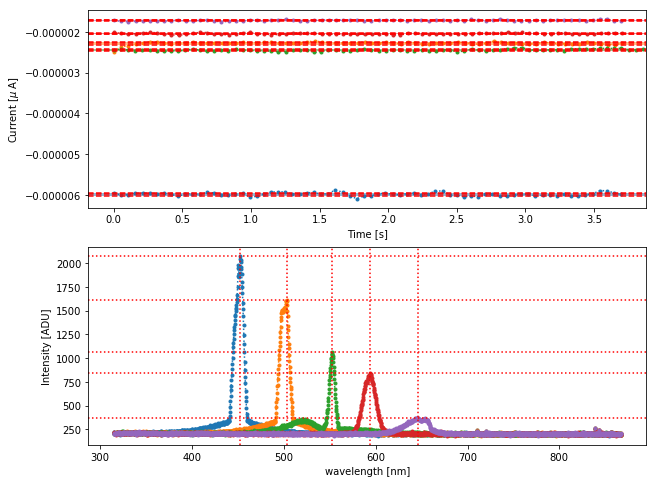

In [11]:
sedSpectrometer_fname=None
electrometer_fname=None

wavelength_arr=np.array([450, 500, 550, 600, 650])
wavelength_max=np.zeros_like(wavelength_arr)

expt_time = 2

fig1 = py.figure(1, figsize=(10, 8))

ax1 = fig1.add_subplot(212)
ax2 = fig1.add_subplot(211)

for i,wave in enumerate(wavelength_arr):
    cmd_id = sender.atMonochromator.send_Command('updateMonochromatorSetup',gratingType=1,
                                             fontExitSlitWidth = 4.0, 
                                             fontEntranceSlitWidth = 2.0,
                                             wavelength = wave, wait_command=True)
    
    # Will not wait for this command, so we can capture a spectrum simultanesly 
    cmd_id2 = sender.calibrationElectrometer.send_Command('StartScanDt', 
                                                          electId=1, time=expt_time+2, 
                                                          wait_command=False)
    # wait a second before starting to capture
    time.sleep(1)
    # setup SED Spectrograph
    cmd_id = sender.sedSpectrometer.send_Command('captureSpectImage', imageType='test',
                                                 integrationTime=expt_time, lamp='lamp',
                                                 wait_command=True)
    # wait a second after spectrum is captured
    time.sleep(1)
    
    # wait for the new sedSpectrometer LargeFileObject to arrive
    sedSpectrometer_fname=wait_for_data(sedSpectrometer_fname, sedSpectrometer)
    if sedSpectrometer_fname is None:
        raise IOError('No sedSpectrometer data returned...')
    # wait for the new electrometer LargeFileObject to arrive        
    electrometer_fname=wait_for_data(electrometer_fname, calibrationElectrometer)
    if electrometer_fname is None:
        raise IOError('No electrometer data returned...')

    #
    # Plot sedSpectrometer data
    #
    print('Opening %s' % sedSpectrometer_fname)
    hdu = fits.open(sedSpectrometer_fname)
    data =hdu[0].data.T
    
    mean = np.mean(data[1])
    std = np.std(data[1])

    ax1.plot(data[0],data[1],'.:')

    nmax = np.argmax(data[1])
    
    # Store wavelenght with max intensity
    wavelength_max[i] = data[0][nmax]
    
    ylim = ax1.get_ylim()
    xlim = ax1.get_xlim()
    ax1.plot([data[0][nmax],data[0][nmax]],ylim,'r:')
    ax1.plot(xlim,[data[1][nmax],data[1][nmax]],'r:')

    print('Wavelength of max Intensity for {} - {} (Delta: {})'.format(wave, data[0][nmax], wave-data[0][nmax]))
    ax1.set_ylim(ylim)
    ax1.set_xlim(xlim)
    
    #
    # Plot electrometer data
    #
    print('Opening %s' % electrometer_fname)
    hdu = fits.open(electrometer_fname)
    data =hdu[0].data.T
    
    ax2.plot(data[0],data[1],'.:')

    mean = np.mean(data[1])
    std = np.std(data[1])

    xlim = ax2.get_xlim()
    ax2.fill_between(xlim,[mean-std,mean-std], [mean+std,mean+std],alpha=0.5)
    ax2.plot(xlim, [mean-std,mean-std], 'r--')
    ax2.plot(xlim, [mean,mean], 'r--')
    ax2.plot(xlim, [mean+std,mean+std], 'r--')

    ax2.set_xlim(xlim)
#     ax1.plot([data[0][nmax],data[0][nmax]],ylim,':')
#     print('Wavelength of max Int.: {}'.format(data[0][nmax]))
#     ax1.set_ylim(ylim)


ax1.set_xlabel('wavelength [nm]')
ax1.set_ylabel('Intensity [ADU]')

ax2.set_ylabel('Current [$\\mu$ A]')
ax2.set_xlabel('Time [s]')

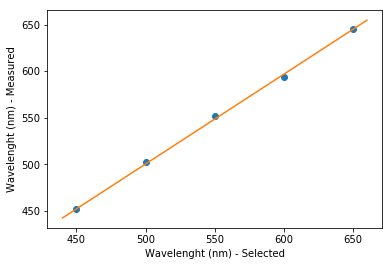

In [12]:
py.plot(wavelength_arr, wavelength_max, 'o')
xlim = py.xlim()
ylim = py.ylim()

py.plot(xlim, ylim)

py.xlabel('Wavelenght (nm) - Selected')
py.ylabel('Wavelenght (nm) - Measured')